## Advanced Python course: Dask Assignment
### Clelia Cervetto MBD O2 | Advanced Python Course

***

### Instructions: Rewrite the Bike Sharing analysis using Dask

##### (Even if the original analysis was done in group, this should be done individually)

- Submission format: A .zip produced by `$ git archive master --format=zip -o LastName_FirstName_Dask.zip` and a link to the GitHub repository, which must be public right after the deadline.

The objective is to rewrite the Bike Sharing analysis done in the Python for Statistical Programming subject using Dask data structures and ecosystem instead of plain pandas.

The reasons for choosing this are:

- The dataset is comparatively small, and the extra computing time is given by feature engineeering and model selection, which lowers the risk
- Everybody has performed this analysis and is relatively familiar with it, which makes it easier than carrying a data science project from scratch, given the time constraints
- Rewriting an existing analysis to make it more performant is more aligned with the objectives of the subject and reflects more real world escenarios
- The "business objectives" are more clear than in the group assignment

The maximum score of the assignment is 4 points and the grading will be as follows:

- **Creation of a git repository with a proper README, incremental commits, and some sort of automatic or programmatic download of the data before the analysis (1 point)**. Notice that the data should not be checked out in the repository. Including data files in git repositories is considered a bad practice.
- **Use of dask.dataframe and distributed.Client for all the data manipulation (2 points)**. Remember that calling .compute() in a Dask DataFrame turns it into a pandas dataframe, which resides in RAM and loses the distributed advantages. The more Dask structures are used, the higher the grade.
- **Use of Dask-ML for distributed training and model selection https://ml.dask.org/ (1 point)**. See below for inspiration.

Useful links:

- Putting everything in a pipeline https://tomaugspurger.github.io/scalable-ml-01.html
- Why Dask-ML is faster than sklearn GridSearchCV for model selection https://jcrist.github.io/introducing-dask-searchcv.html
- JupyterHub on Hadoop https://jcrist.github.io/jupyterhub-on-hadoop/index.html

As you can see, the assignment is more open ended. Use this as a opportunity to explore, and don't be afraid of recording failed experiments in the notebook, if they are properly explained and described.

***

### 1. Imports, client generation

In [18]:
import dask
import dask.dataframe as dd

In [19]:
#pip install s3fs

##### We generate the client. When I use joblib from sklearn (Loky backend) it usually comes up with 8 workers, therefore I chose 8 workers here. 

In [20]:
from dask.distributed import Client, progress
client = Client(n_workers=8, threads_per_worker=2, memory_limit='1GB')
client

C:\Users\Clelia\Anaconda3\lib\site-packages\distributed\bokeh\core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:54357 Dashboard: http://127.0.0.1:54360/status,Cluster Workers: 8 Cores: 16 Memory: 8.00 GB


***

### 2. Data loading and statistics

##### Here we take the data from an AWS S3 public bucket, and when calling the dataframe we can see that it is handled in Dask. Indeed we can read from the Dask documentation that "Unlike Pandas, Dask DataFrames are lazy and so no data is printed", and we only see datatypes inside the columns. 

In [21]:
hour_df = dd.read_csv("https://s3.us-east-2.amazonaws.com/ie-projects-clelia/hour.csv")
hour_df = client.persist(hour_df)
hour_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
npartitions=1,,,,,,,,,,,,,,,,,
,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [22]:
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


##### Descriptive statistics

In [40]:
hour_df.describe().compute().round(3)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_real,heat_index,WCI,v
count,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000
mean,8690.000,2.502,0.503,6.538,11.547,0.029,3.004,0.683,1.425,0.497,0.476,16.630,0.190,35.676,153.787,189.463,15.358,38.193,553.310,12.289
std,5017.029,1.107,0.500,3.439,6.914,0.167,2.006,0.465,0.639,0.193,0.172,12.466,0.122,49.305,151.357,181.388,9.050,11.693,345.375,6.969
min,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.020,0.000,-11.935,0.000,0.000,0.000,1.000,-7.060,3.290,-190.867,0.000
25%,4345.500,2.000,0.000,4.000,6.000,0.000,1.000,0.000,1.000,0.340,0.333,5.725,0.104,4.000,34.000,40.000,7.980,30.062,268.865,5.981
50%,8690.000,3.000,1.000,7.000,12.000,0.000,3.000,1.000,1.000,0.500,0.485,16.202,0.194,17.000,115.000,142.000,15.500,34.631,501.918,10.951
75%,13034.500,3.000,1.000,10.000,18.000,0.000,5.000,1.000,2.000,0.660,0.621,27.604,0.254,48.000,220.000,281.000,23.020,42.357,817.553,18.283
max,17379.000,4.000,1.000,12.000,23.000,1.000,6.000,1.000,4.000,1.000,1.000,48.359,0.851,367.000,886.000,977.000,39.000,112.189,1993.249,32.745


##### Missing values

In [41]:
hour_df.isnull().sum().compute()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
temp_real     0
heat_index    0
WCI           0
v             0
dtype: int64

### 3. Data handling and feature engineering

- ### INDEXATION

- ### CATEGORICAL vs. NUMERICAL VALUES

- ### NUMERICAL VALUES HANDLING: OUTLIERS REMOVAL

- ### FEATURE CREATION

##### Heat index
Normalized temperature can be used to calculate real temperature in Celcius which can be used to calculate the head index (HI) as well as wind chill index (WCI) which may or may not correlate with our target variable.

Given the equation used to normalize temperature, (t-t_min)/(t_max-t_min) where t_max is 39 and t_min is -8, we can derive the equation for temperature to be as follows:

temp_real = 47*temp - 8

In [23]:
# Calculate the real temperature using the above equation
hour_df["temp_real"] = 47 * hour_df["temp"] - 8

Using the results from real temperature in Celcius, we can use these values to calculate the heat index or humiture (HI), which is an index that combines air temperature and relative humidity. The formula used for calculation is as follows:
HI = c1 + c2T + c3R + c4TR + c5T^2 + c6R^2 + c7RT^2 + c8TR^2 + c9T^2R^2
where T is the temperature (in degrees Celcius) and R is the relative humidity (percentage value between 0 and 100)

- c1 = −8.78469475556,
- c2 = 1.61139411,
- c3 = 2.33854883889,
- c4 = -0.14611605,
- c5 = -0.012308094,
- c6 = -0.0164248277778,
- c7 = 0.002211732,
- c8 = 0.00072546,
- c9 = -0.000003582,

In [24]:
hour_df["heat_index"] = (
    -8.78469475556
    + (1.61139411 * (hour_df["temp_real"]))
    + (2.33854883889 * hour_df["hum"] * 100)
    + (-0.14611605 * hour_df["temp_real"] * hour_df["hum"] * 100)
    + (-0.012308094 * (hour_df["temp_real"]) ** 2)
    + (-0.0164248277778 * (hour_df["hum"] * 100) ** 2)
    + (
        0.002211732
        * ((hour_df["temp_real"]) ** 2)
        * (hour_df["hum"] * 100)
    )
    + (0.00072546 * hour_df["temp_real"] * (hour_df["hum"] * 100) ** 2)
    + (
        -0.000003582
        * ((hour_df["hum"] * 100) * 2)
        * ((hour_df["temp_real"]) * 2)
    )
)

In [25]:
hour_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_real,heat_index
npartitions=1,,,,,,,,,,,,,,,,,,,
,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


##### Wind Chill Index (WCI)
We can also calculate the Wind Chill Index (WCI) which is the lowering of body temperature due to the passing-flow of lower-temperature air. 

The formula used is as follows:
WCI = (10*SQRT(windspeed) - windspeed + 10.5)*(33 - temp_real)

where:

WCI = wind chill index, kcal/m2/h
v = wind velocity, m/s
Ta = air temperature, °C

since our wind speed is in km/h we will use a 0.277778 coefficient to convert it to m/s

In [26]:
import numpy as  np
hour_df["WCI"] = (
    10 * np.sqrt(hour_df["windspeed"] * 0.277778 * 100)
    - (0.277778 * hour_df["windspeed"])
    + 10.5
) * (33 - hour_df["temp_real"])

In [27]:
hour_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,temp_real,heat_index,WCI
npartitions=1,,,,,,,,,,,,,,,,,,,,
,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


##### Humidity Index (HUMIDEX)
The humidex (“humidity Index”, abbreviated to HX in the present study) is a measure of the combined effect of heat and humidity on human physiology. It is calculated from air temperature and relative humidity. First, the vapour pressure of water v (in hPa) is calculated using:

v = (6.112 × 10ˆ(7.5*T/(237.7 + T)) * RH/100)

where T = air temperature (°C) and RH is the relative humidity (%). 

The Humidex (HX) is then found using:
HX = T + (v − 10) * 5 / 9

In [29]:
hour_df["v"] = (
    6.112 * 10 ** (7.5 * hour_df["temp_real"] / (237.7 + hour_df["temp_real"]))
) * (hour_df["hum"])

hour_df["hum"] = hour_df["temp_real"] + ((hour_df["v"] - 10) * (5 / 9))

- ### CORRELATION MATRIX

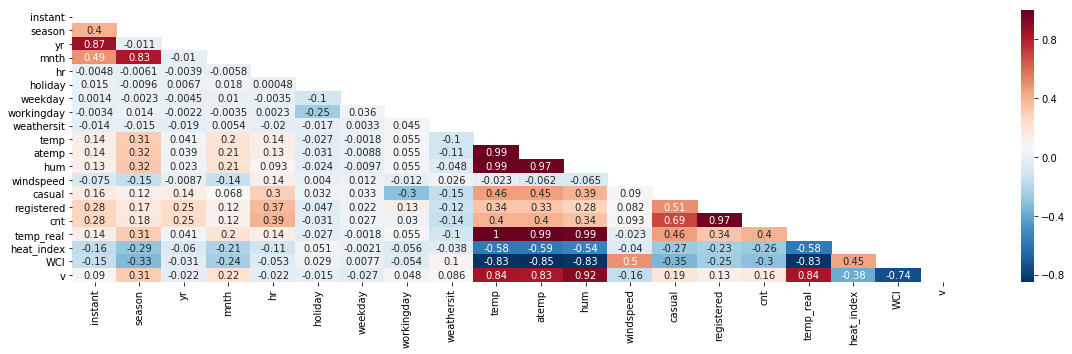

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(20, 5))
mask = np.zeros_like(hour_df.compute().corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(hour_df.compute().corr(), cmap="RdBu_r", mask=mask, annot=True)

- ### CATEGORICAL VALUES HANDLING: DUMMIFICATION

- ### MULTICOLLINEARITY ISSUES

- ### FEATURE SELECTION

### 4. TRAIN TEST SPLIT

### 5. MODELING AND DASK ML

### Gradient Boosting

In [ ]:
# Grid Search
parameters_bgr = [
    {
        "n_estimators": [200, 400, 500, 700],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "max_features": ["auto", "sqrt", "log2"],
        "min_samples_leaf": [3, 5],
    }
]
grid_search_gbr = GridSearchCV(estimator=model_gbr, param_grid=parameters_bgr)
grid_search_gbr = grid_search_gbr.fit(X_train, y_train)
best_parameters_gbr = grid_search_gbr.best_params_
best_accuracy_gbr = grid_search_gbr.best_score_

In [ ]:
# check the best parameters to be used
best_parameters_gbr

In [ ]:
best_accuracy_gbr

In [ ]:
# Use the best parameters found from above to build the model
gbr_new = GradientBoostingRegressor(
    n_estimators=700,
    max_features="log2",
    max_depth=7,
    learning_rate=0.1,
    min_samples_leaf=3,
)
gbr_new.fit(X_train, y_train)

# Predicting the values
gbr_pred_2 = gbr_new.predict(X_test)

gbr_pred_2 = [
    i if i >= 0 else 0 for i in gbr_pred_2
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
gbr_pred_2 = [round(x) for x in gbr_pred_2]

In [ ]:
# Comparing predicted values with true values in testing set
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, gbr_pred_2)))
print("R2: %.2F" % r2_score(y_test, gbr_pred_2))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, gbr_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

In [ ]:
sns.distplot(y_test - gbr_pred_2, bins=30)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

predict = cross_val_predict(gbr_new, X_train, y_train, cv=10)

# Evaluating model in cross-validation iteration
r2_scores = cross_val_score(gbr_new, X_train, y_train, cv=10)
mse = cross_val_score(
    gbr_new, X_train, y_train, cv=10, scoring="neg_mean_squared_error"
)
accuracy = cross_val_score(estimator=gbr_new, X=X_train, y=y_train, cv=10)

fig, ax = plt.subplots()
ax.plot(range(0, 10), r2_scores)
ax.set_xlabel("Iteration")
ax.set_ylabel("R.Squared")
ax.set_title("Cross-Validation scores")
plt.show()


print("R-squared::{}".format(r2_scores))
print("Mean Accuracy::{}".format(accuracy.mean()))